In [1]:
pwd

u'/Users/linzeyang'

In [2]:
cd Desktop/BIA-660/Final Project/data

/Users/linzeyang/Desktop/BIA-660/Final Project/data


### Increasing rate of Cumulative trip since 2015 becomes small, we consider it plateaued

so, I used 2015,2016 data for training, and 2017 for testing.
More specific, I trained data by season, so for each season there are 3 (month/year) * 2 (year) = 6 months
For later testing, you only need to identify which season it belongs to.

In [3]:
import pandas as pd
import numpy as np
import re
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from six.moves import urllib
import json
import collections
import itertools
import requests
import time
import pandas as pd
from  __builtin__ import any as b_any
import math
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline


/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# glob.glob("2016*.csv")

In [ ]:
# glob.glob("../in/sales*.xlsx")
# all_data = pd.DataFrame()
# for f in glob.glob("2016*.csv"):
#     df = pd.read_csv(f)
#     all_data = all_data.append(df,ignore_index=True)

## Integrate Variables & Data Preprocess

In [4]:
# =========== Pre-process ==========
df = pd.read_csv('201612-citibike-tripdata.csv')
#df = pd.read_csv('201608-citibike-tripdata.csv')
#df = all_data
# Missing values in columns
#print(df.isnull().sum())
# Snake_case the columns
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).replace(' ','').lower()
df.columns = [camel_to_snake(col) for col in df.columns]

# Parse start_time and stop_time
try:
    df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df.start_time]
#except ValueError:
    #df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M') for x in df.start_time]
except ValueError:
     df['start_datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df.start_time]
df['start_day'] = [x.strftime('%Y-%m-%d') for x in df.start_datetime]

# =========== Group by date and station ===========
df['bikein'] = 1
df['bikeout'] = 1

df_bikeout = df.groupby(by=['start_stationid', 'start_day'])['bikeout'].count()
df_bikeout = pd.DataFrame(df_bikeout)
df_out = df_bikeout.reset_index(drop = False)
df_out.rename_axis({'start_stationid':'station_id'}, axis='columns', inplace=True)
print(df_out.head())

df_bikein = df.groupby(by=['end_stationid', 'start_day'])['bikein'].count()
df_bikein = pd.DataFrame(df_bikein)
df_in = df_bikein.reset_index(drop = False)
df_in.rename_axis({'end_stationid':'station_id'}, axis='columns', inplace=True)
#print(df_in.head())

# =========== Bike loss per day for each station ===========
# Merge two DFs by station_id
df_dayloss = df_out.merge(right=df_in, left_on=['station_id', 'start_day'], right_on=['station_id', 'start_day'],
                          how='outer')
df_dayloss = df_dayloss.sort_values(['station_id', 'start_day'])
df_dayloss = df_dayloss.fillna(0)
df_dayloss['bike_loss'] = df_dayloss['bikeout'] - df_dayloss['bikein']
print(df_dayloss[1:5])

   station_id   start_day  bikeout
0          72  2016-12-01      100
1          72  2016-12-02       92
2          72  2016-12-03       53
3          72  2016-12-04       47
4          72  2016-12-05       78
   station_id   start_day  bikeout  bikein  bike_loss
1          72  2016-12-02     92.0    85.0        7.0
2          72  2016-12-03     53.0    50.0        3.0
3          72  2016-12-04     47.0    60.0      -13.0
4          72  2016-12-05     78.0    62.0       16.0


In [5]:
df_dayloss[df_dayloss.station_id==72][1:5]

,station_id,start_day,bikeout,bikein,bike_loss
1,72,2016-12-02,92.0,85.0,7.0
2,72,2016-12-03,53.0,50.0,3.0
3,72,2016-12-04,47.0,60.0,-13.0
4,72,2016-12-05,78.0,62.0,16.0


In [6]:
# append weekday_index column
#wekday_name=pd.to_datetime(df_dayloss.start_day).dt.weekday_name   #name
df_wekday_index=pd.to_datetime(df_dayloss.start_day).dt.weekday   # index Monday=0, Sunday=6
# Append weekday column to df_dayloss
df_dayloss['wek_index']=df_wekday_index

In [7]:
# =========== count docks Then append to dayloss============
jsonurl = urllib.request.urlopen('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
text = json.loads(jsonurl.read()) # <-- read from it
data=text['data']
#print(len(data['stations']))   664 stations
#print(data['stations'][0]['station_id']) # station id

# station id Extract:
total_stations_id = []
for i in range(len(data['stations'])):
    id=data['stations'][i]['station_id']
    total_stations_id.append(id)
total_stations_id=[int(x) for x in total_stations_id]
#print('station_id list:'+str(total_stations_id))

# num_bikes_available Extract:
total_num_bikes_available = []
for i in range(len(data['stations'])):
    num_bikes_available = data['stations'][i]['num_bikes_available']
    total_num_bikes_available.append(num_bikes_available)
#print('bikes availble:'+str(total_num_bikes_available))

# num_docks_available Extract:
total_docks_available = []
for i in range(len(data['stations'])):
    docks_availble=data['stations'][i]['num_docks_available']
    total_docks_available.append(docks_availble)
#print('docks availble:'+str(total_docks_available))

total_docks=[x + y for x, y in zip(total_num_bikes_available, total_docks_available)]
#print('total docks for each station:'+str(total_docks))
#to_dict

new_dict = dict(zip(total_stations_id,total_docks))
#print('zip station_id and total docks:'+str(new_dict))

# append docks to df_dayloss
df_dayloss['docks'] = df_dayloss['station_id'].map(new_dict)


In [8]:
# Append holiday column to df_dayloss
holiday = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15',
          '2016-05-08', '2016-05-30', '2016-06-19', '2016-07-04',
          '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24',
          '2016-12-26']
df_dayloss['holiday_idx'] = df_dayloss['start_day'].apply(lambda x: 1 if (x in holiday) else 0)


## Get Weather Data 

    1.  Get highest temperature of that day 
    2.  Get Weather Condition (Sunny, Rainy...)
    Note: Since the Weather Condition we extract for the day is the condition that appears most frequently in 8 equal 
    time piece of the day(0-3, 3-6...), so we didn't use the amount of rain, instead we just simply used whether there     is rain or not.
  

In [10]:
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    each_day_weather_set = []
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=c3e90d1cd020454594c203537172604&q=NY&date=' + x + '&format=json'       # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"
        
        k = r.json()
        
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
    new_dict = dict(zip(dates, maxtempF))
    new_dict2 = dict(zip(dates, each_day_weather_set))
    #print each_day_weather_set
    #print dates
    df_climate['High_temp'] = df_climate['start_day'].map(new_dict)
    df_climate['Climate_type'] = df_climate['start_day'].map(new_dict2)
    return df_climate
time.sleep(0.2)
weather_Data(df_dayloss)

,station_id,start_day,bikeout,bikein,bike_loss,wek_index,docks,holiday_idx,High_temp,Climate_type
0,72,2016-12-01,100.0,90.0,10.0,3,38.0,0,55,Sunny
1,72,2016-12-02,92.0,85.0,7.0,4,38.0,0,46,Sunny
2,72,2016-12-03,53.0,50.0,3.0,5,38.0,0,44,Sunny
3,72,2016-12-04,47.0,60.0,-13.0,6,38.0,0,42,Overcast
4,72,2016-12-05,78.0,62.0,16.0,0,38.0,0,49,Light
5,72,2016-12-06,72.0,72.0,0.0,1,38.0,0,46,Overcast
6,72,2016-12-07,80.0,84.0,-4.0,2,38.0,0,47,rain
7,72,2016-12-08,74.0,84.0,-10.0,3,38.0,0,42,Freezing
8,72,2016-12-09,68.0,58.0,10.0,4,38.0,0,37,Sunny
9,72,2016-12-10,38.0,34.0,4.0,5,38.0,0,36,Clear


In [11]:
set(df_dayloss.Climate_type)

{'Clear', 'Fog', 'Freezing', 'Light', 'Overcast', 'Partly', 'Sunny', 'rain'}

## change categorical variables to dummy variables:

    1. wek_index: Weekday:0; Weekend:1
    2. holiday_index: Non-holiday:0; Holiday:1
    3. High_temp: continuous
    4. Climate_type(Sunny, Rainy....): Dummy Variables.

In [11]:
# Assign weekday = 0 and weekend = 1
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([1,2,3,4],[0,0,0,0])
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([5,6],[1,1])   # weekend

# Get Dummy Variables for 'Climate Type'
dummy_weather=pd.get_dummies(df_dayloss['Climate_type'])
df_dayloss = pd.concat([df_dayloss, dummy_weather], axis=1)

# Remove docks col 
del df_dayloss['docks']

# Remove Climate_type col
del df_dayloss['Climate_type']


## 1.Since we will use cross validation (k=10) later(for each station), we need to clean our raw data to make sure for each station, there are enough instances for cross validation.


In [115]:
lon_set=[]
lat_set=[]
geo_id = []
for i in set(df_dayloss['station_id']):
    try:
        lat_set.append(df.loc[df['start_stationid'] == i, 'start_station_latitude'].iloc[0])
        lon_set.append(df.loc[df['start_stationid'] == i, 'start_station_longitude'].iloc[0])
        geo_id.append(i)
    except:
        continue

In [119]:
len(lat_set) # 609
len(lon_set)  #609
geo_set = pd.concat([pd.DataFrame(geo_id),pd.DataFrame(lat_set),pd.DataFrame(lon_set)],axis=1)
len(geo_set)  # 609
geo_set

,0,0,0
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,116,40.741776,-74.001497
5,119,40.696089,-73.978034
6,120,40.686768,-73.959282
7,127,40.731724,-74.006744
8,128,40.727103,-74.002971
9,143,40.692395,-73.993379


In [12]:
len(set(df_dayloss['station_id']))

613

In [13]:
# Delete station that has less than 20 samples (Not good for CV)
station_id_set = list(set(df_dayloss['station_id']))
useless_ids_index = []
for i in station_id_set:
    sample_size=len(df_dayloss[df_dayloss['station_id']==i])
    if sample_size < 20:
        useless_ids_index.append(station_id_set.index(i))
station_id_set=np.delete(station_id_set, useless_ids_index).tolist()
len(station_id_set)

597

## Some Visilizations
    1. Average bike_loss for each station

(-5, 5)

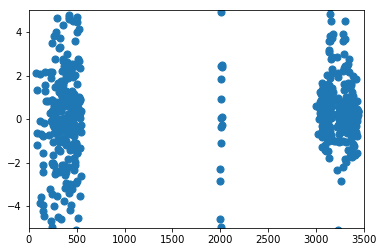

In [16]:
avg_loss=df_dayloss.groupby('station_id', as_index=False)['bike_loss'].mean()
plt.scatter(avg_loss.station_id, avg_loss.bike_loss,s=50)
axes = plt.gca()
axes.set_xlim([0,3500])
axes.set_ylim([-5,5])

In [17]:
small_sta_id=avg_loss[avg_loss.station_id<=2000]
print small_sta_id.describe()
large_sta_id=avg_loss[avg_loss.station_id>2000]
print large_sta_id.describe()


        station_id   bike_loss
count   291.000000  291.000000
mean    372.065292   -0.650924
std     147.551134    5.484967
min      72.000000  -49.677419
25%     290.000000   -1.903226
50%     376.000000    0.032258
75%     459.500000    1.274194
max    2000.000000   19.032258
        station_id   bike_loss
count   322.000000  322.000000
mean   3185.173913    0.605777
std     279.837081    3.272735
min    2001.000000  -11.806452
25%    3108.250000   -0.322581
50%    3238.500000    0.193548
75%    3349.750000    0.838710
max    3440.000000   33.818182


## Tune parameters --- Random Search & Grid Search

    1. Random Search: use random search to find good starting points, 
    2. Grid search: to zoom in and find the local optima (or close to it) for those good starting points

## Tune Parameters For Each Model-- Grid Search

Description:
Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

     1. Random Forest
     2. Lasso
     3. Ridge
     4. MLP
     
NOTE: GRID SEARCH WILL FILTER STATIONS THAT DESN'T MEET THE REQUIREMENT!(SAMPLE SIZE AT THAT STATION IS TOO SMALL TO CV)

In [14]:
from sklearn.model_selection import GridSearchCV
parameter_box=[]
RF:
reg_type = RandomForestRegressor()
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 9]}
  ]

Lasso:
reg_type = linear_model.Lasso()
param_grid = [{'alpha':[0,000.1,0.01,0.1,1,2,5,10.2,12.4,15,18]}]


# MLPRegressor -- Neural Network
reg_type = MLPRegressor()
param_grid = [{ 'hidden_layer_sizes':[(5),(50),(50,100),(100,50,100)],
        'activation':['relu','identity', 'logistic', 'tanh'] ,
        'max_iter':[50,200,500],
        }]

def grid_search(reg_type,param_grid):
    grid_search = GridSearchCV(reg_type, param_grid, cv=5,
                               scoring='neg_mean_squared_error',n_jobs=-1)
    for i in station_id_set:
        try:
            
            a=df_dayloss[df_dayloss['station_id']==i]
            X=a.ix[:,5:16]
            y=a.ix[:,4]
            grid_search.fit(X, y)
            print grid_search.best_params_
            parameter_box.append(grid_search.best_params_)
        except:
            print i
            continue
grid_search(reg_type,param_grid)

/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged y

{'activation': 'identity', 'max_iter': 500, 'hidden_layer_sizes': 5}


/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


{'activation': 'tanh', 'max_iter': 200, 'hidden_layer_sizes': 50}
{'activation': 'identity', 'max_iter': 50, 'hidden_layer_sizes': 50}
{'activation': 'logistic', 'max_iter': 50, 'hidden_layer_sizes': 5}
{'activation': 'identity', 'max_iter': 500, 'hidden_layer_sizes': 50}
{'activation': 'relu', 'max_iter': 50, 'hidden_layer_sizes': 50}
{'activation': 'identity', 'max_iter': 200, 'hidden_layer_sizes': 50}
{'activation': 'tanh', 'max_iter': 500, 'hidden_layer_sizes': 50}
{'activation': 'relu', 'max_iter': 50, 'hidden_layer_sizes': 50}
{'activation': 'logistic', 'max_iter': 500, 'hidden_layer_sizes': 50}
{'activation': 'tanh', 'max_iter': 50, 'hidden_layer_sizes': 5}
{'activation': 'identity', 'max_iter': 50, 'hidden_layer_sizes': 50}
{'activation': 'identity', 'max_iter': 200, 'hidden_layer_sizes': 5}
{'activation': 'tanh', 'max_iter': 500, 'hidden_layer_sizes': (50, 100)}
{'activation': 'tanh', 'max_iter': 50, 'hidden_layer_sizes': 5}
{'activation': 'tanh', 'max_iter': 50, 'hidden_layer

In [383]:
Lasso_para_value = [x['alpha'] for x in parameter_box]


In [15]:
MLP_para_value1=[x['activation'] for x in parameter_box]
MLP_para_value2=[x['hidden_layer_sizes'] for x in parameter_box]
MLP_para_value3=[x['max_iter'] for x in parameter_box]


In [400]:
RF_para_value1=[x['max_features'] for x in parameter_box]
RF_para_value2=[x['n_estimators'] for x in parameter_box]


In [403]:
para_all=pd.concat([pd.DataFrame(Lasso_para_value),pd.DataFrame(MLP_para_value1),pd.DataFrame(MLP_para_value2),
                   pd.DataFrame(MLP_para_value3),pd.DataFrame(RF_para_value1),pd.DataFrame(RF_para_value2)],axis=1)


In [408]:
para_all.columns=['Lasso-Alpha','MLP-Activation','MLP-HiddenLayerSize','MLP-MaxIter','RF-MaxFeatures','RF-NEstimates']


In [420]:
print len(para_all)
print len(station_id_set)


597
597


In [418]:
para_all.index=station_id_set


## Linear Regression 

    1. Linear regression for each station(December)
    2. Coff Analysis (Larger coff represents for larger effect of that variable)
    3. Significant test for each independent variable
    4. R^2 & accuracy of Linear Regression Model (When test data coming in)


# Cross Validation

1. CV for different models.
note: useless_id_index generated in linear regression CV

##  Cross Validation -- Linear Regression

In [422]:
LR_CV_score_set = []
LR_culmilative_set = []
# Count RMSE (Root Mean Squared Error) for every station 
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    linearReg = LinearRegression()
    mean_CV_score = math.sqrt(-(cross_val_score(linearReg, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
    #print 'CV score for station %s is: '%i +str(mean_CV_score)
    LR_CV_score_set.append(mean_CV_score)
    LR_culmilative_set.append(np.mean(LR_CV_score_set))

print 'Mean Score of Cross Validation using Linear Regression is:' + str(np.mean(LR_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Linear Regression is:' + str(np.std(LR_CV_score_set))


Mean Score of Cross Validation using Linear Regression is:8.54144973593
Standard Deviation Score of Cross Validation using Linear Regression is:5.53159725278


## Cross Validation - Lasso

In [347]:
lasso_CV_score_set = []
lasso_culmilative_set = []
for i, j in zip(list(station_id_set), para_value):   # loop simultaneously
    a=df_dayloss[df_dayloss['station_id']==i]    
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    lasso = linear_model.Lasso(alpha=j)
    mean_CV_score = math.sqrt(-(cross_val_score(lasso, X, y,cv=5, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    lasso_CV_score_set.append(mean_CV_score)
    lasso_culmilative_set.append(np.mean(lasso_CV_score_set))
print 'Mean Score of Cross Validation using Lasso Regression is: ' + str(np.mean(lasso_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Lasso Regression is: ' + str(np.std(lasso_CV_score_set))


CV score for station 72 is: 8.1761442964
CV score for station 79 is: 6.15258401544
CV score for station 82 is: 3.50933164243
CV score for station 83 is: 7.93287920665
CV score for station 116 is: 10.705575495
CV score for station 119 is: 2.20501391212
CV score for station 120 is: 3.56614435717
CV score for station 127 is: 6.15770090175
CV score for station 128 is: 6.81363524981
CV score for station 143 is: 6.86304338584
CV score for station 144 is: 3.64901513132
CV score for station 146 is: 8.27805317482
CV score for station 147 is: 6.03813047252
CV score for station 150 is: 12.4568341615
CV score for station 151 is: 14.1949760348
CV score for station 152 is: 7.80367320917
CV score for station 153 is: 16.6386386308
CV score for station 157 is: 5.33194302563
CV score for station 161 is: 8.49757962417
CV score for station 164 is: 9.9511892281
CV score for station 167 is: 6.28891278741
CV score for station 168 is: 14.9696374901
CV score for station 173 is: 11.6511517556
CV score for stati

In [309]:
print len(station_id_set)
print len(dict_value)

603
603


## Random Forest

    1. Importance of Each Feature
    2. Accuracy of Random Forest Model

## Cross Validation --- Random Forest

In [405]:
RF_CV_score_set = []
RF_culmilative_set = []
for i,j,k in zip(set(df_dayloss['station_id']),RF_para_value1,RF_para_value2):
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    rf = RandomForestRegressor(max_features=j,n_estimators=k)
    mean_CV_score = math.sqrt(-(cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    RF_CV_score_set.append(mean_CV_score)
    RF_culmilative_set.append(np.mean(RF_CV_score_set))
    

CV score for station 72 is: 10.0044739992
CV score for station 79 is: 6.88756769365
CV score for station 82 is: 4.52242662656
CV score for station 83 is: 7.60985405137
CV score for station 116 is: 10.8605542625
CV score for station 119 is: 2.61667728236
CV score for station 120 is: 4.10668233047
CV score for station 127 is: 7.20654794845
CV score for station 128 is: 8.82929939337
CV score for station 143 is: 7.86940780606
CV score for station 144 is: 4.15331639019
CV score for station 146 is: 9.48784017104
CV score for station 147 is: 7.2194586593
CV score for station 150 is: 14.0165378512
CV score for station 151 is: 16.7082719589
CV score for station 152 is: 10.2812211949
CV score for station 153 is: 21.1949994102
CV score for station 157 is: 5.4914175462
CV score for station 161 is: 9.79176713896
CV score for station 164 is: 10.0382801779
CV score for station 167 is: 7.03937339383
CV score for station 168 is: 16.5536165904
CV score for station 173 is: 13.117815494
CV score for stati

In [406]:
print 'Mean Score of Cross Validation using Random Forest is: ' + str(np.mean(RF_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Random Forest is: ' + str(np.std(RF_CV_score_set))


Mean Score of Cross Validation using Random Forest is: 8.37967361665
Standard Deviation Score of Cross Validation using Random Forest is: 5.58708110836


## Cross Validation -- Neural Network

      1.  MLP: Multi-layer Perceptron

In [141]:
from sklearn.neural_network import MLPRegressor
MLP_CV_score_set = []
MLP_culmilative_set = []
for i,j,k,p in zip(list(station_id_set),MLP_para_value1,MLP_para_value2,MLP_para_value3):
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    MLP = MLPRegressor(activation=j,hidden_layer_sizes=k,max_iter=p)
    mean_CV_score = math.sqrt(-(cross_val_score(MLP, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    MLP_CV_score_set.append(mean_CV_score)
    MLP_culmilative_set.append(np.mean(MLP_CV_score_set))
    

NameError: name 'MLP_para_value1' is not defined

In [381]:
print 'Mean Score of Cross Validation using MLP is: ' + str(np.mean(MLP_CV_score_set))
print 'Standard Deviation Score of Cross Validation using MLP is: ' + str(np.std(MLP_CV_score_set))

Mean Score of Cross Validation using MLP is: 7.45055821364
Standard Deviation Score of Cross Validation using MLP is: 4.75385130278


## RF better than LR !

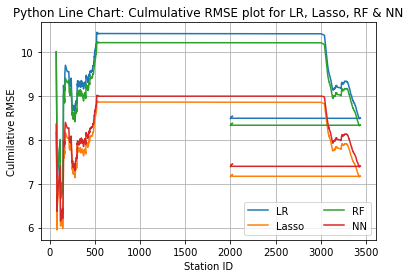

In [446]:
# The total RMASE is counted by average rmse of all stations
# For each model(LR & RF), the culmulative RMSE changes when new station coming in.
from pylab import *
t1 = LR_culmilative_set
t2 = lasso_culmilative_set
t3 = RF_culmilative_set
t4 = MLP_culmilative_set

s = station_id_set
plt.plot(s, t1, label='LR')
plt.plot(s, t2, label='Lasso')
plot(s, t3, label='RF')
plot(s, t4, label='NN')
xlabel('Station ID')
ylabel('Culmilative RMSE')
title('Python Line Chart: Culmulative RMSE plot for LR, Lasso, RF & NN')
grid(True)
plt.legend(loc='lower right',ncol=2)
plt.show()


## Testing

In [16]:
# =========== Preparing test data==========
df = pd.read_csv('201611-citibike-tripdata.csv')
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).replace(' ','').lower()
df.columns = [camel_to_snake(col) for col in df.columns]
try:
    df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df.start_time]
#except ValueError:
    #df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M') for x in df.start_time]
except ValueError:
     df['start_datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df.start_time]
df['start_day'] = [x.strftime('%Y-%m-%d') for x in df.start_datetime]
# =========== Group by date and station ===========
df['bikein'] = 1
df['bikeout'] = 1
df_bikeout = df.groupby(by=['start_stationid', 'start_day'])['bikeout'].count()
df_bikeout = pd.DataFrame(df_bikeout)
df_out = df_bikeout.reset_index(drop = False)
df_out.rename_axis({'start_stationid':'station_id'}, axis='columns', inplace=True)
df_bikein = df.groupby(by=['end_stationid', 'start_day'])['bikein'].count()
df_bikein = pd.DataFrame(df_bikein)
df_in = df_bikein.reset_index(drop = False)
df_in.rename_axis({'end_stationid':'station_id'}, axis='columns', inplace=True)
# =========== Bike loss per day for each station ===========
df_dayloss_test = df_out.merge(right=df_in, left_on=['station_id', 'start_day'], right_on=['station_id', 'start_day'],
                          how='outer')
df_dayloss_test = df_dayloss_test.sort_values(['station_id', 'start_day'])
df_dayloss_test = df_dayloss_test.fillna(0)
df_dayloss_test['bike_loss'] = df_dayloss_test['bikeout'] - df_dayloss_test['bikein']
print(df_dayloss_test[1:5])
df_wekday_index=pd.to_datetime(df_dayloss_test.start_day).dt.weekday   # index Monday=0, Sunday=6
df_dayloss_test['wek_index']=df_wekday_index
holiday = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15',
          '2016-05-08', '2016-05-30', '2016-06-19', '2016-07-04',
          '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24',
          '2016-12-26']
df_dayloss_test['holiday_idx'] = df_dayloss_test['start_day'].apply(lambda x: 1 if (x in holiday) else 0)

   station_id   start_day  bikeout  bikein  bike_loss
1          72  2016-11-02    119.0   130.0      -11.0
2          72  2016-11-03    146.0   144.0        2.0
3          72  2016-11-04    129.0   108.0       21.0
4          72  2016-11-05     92.0   109.0      -17.0


In [17]:
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    each_day_weather_set = []
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=c3e90d1cd020454594c203537172604&q=NY&date=' + x + '&format=json'       # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"
        
        k = r.json()
        
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
    new_dict = dict(zip(dates, maxtempF))
    new_dict2 = dict(zip(dates, each_day_weather_set))
    #print each_day_weather_set
    #print dates
    df_climate['High_temp'] = df_climate['start_day'].map(new_dict)
    df_climate['Climate_type'] = df_climate['start_day'].map(new_dict2)
    return df_climate
time.sleep(0.2)
weather_Data(df_dayloss_test)

,station_id,start_day,bikeout,bikein,bike_loss,wek_index,holiday_idx,High_temp,Climate_type
0,72,2016-11-01,133.0,127.0,6.0,1,0,60,Sunny
1,72,2016-11-02,119.0,130.0,-11.0,2,0,76,Sunny
2,72,2016-11-03,146.0,144.0,2.0,3,0,75,Overcast
3,72,2016-11-04,129.0,108.0,21.0,4,0,59,Sunny
4,72,2016-11-05,92.0,109.0,-17.0,5,0,61,Sunny
5,72,2016-11-06,96.0,90.0,6.0,6,0,57,Sunny
6,72,2016-11-07,116.0,105.0,11.0,0,0,58,Sunny
7,72,2016-11-08,128.0,137.0,-9.0,1,0,71,Sunny
8,72,2016-11-09,87.0,80.0,7.0,2,0,59,Light
9,72,2016-11-10,128.0,117.0,11.0,3,0,54,Partly


In [18]:
# Assign weekday = 0 and weekend = 1
df_dayloss_test['wek_index']=df_dayloss_test['wek_index'].replace([1,2,3,4],[0,0,0,0])
df_dayloss_test['wek_index']=df_dayloss_test['wek_index'].replace([5,6],[1,1])   # weekend

# Get Dummy Variables for 'Climate Type'
dummy_weather=pd.get_dummies(df_dayloss_test['Climate_type'])
df_dayloss_test = pd.concat([df_dayloss_test, dummy_weather], axis=1)

# Remove docks col 
#del df_dayloss['docks']

# Remove Climate_type col
del df_dayloss_test['Climate_type']


In [32]:
# =========== count docks Then append to dayloss============
jsonurl = urllib.request.urlopen('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
text = json.loads(jsonurl.read()) # <-- read from it
data=text['data']
#print(len(data['stations']))   664 stations
#print(data['stations'][0]['station_id']) # station id

# station id Extract:
total_stations_id = []
for i in range(len(data['stations'])):
    id=data['stations'][i]['station_id']
    total_stations_id.append(id)
total_stations_id=[int(x) for x in total_stations_id]
#print('station_id list:'+str(total_stations_id))

# num_bikes_available Extract:
total_num_bikes_available = []
for i in range(len(data['stations'])):
    num_bikes_available = data['stations'][i]['num_bikes_available']
    total_num_bikes_available.append(num_bikes_available)
#print('bikes availble:'+str(total_num_bikes_available))

# num_docks_available Extract:
total_docks_available = []
for i in range(len(data['stations'])):
    docks_availble=data['stations'][i]['num_docks_available']
    total_docks_available.append(docks_availble)
#print('docks availble:'+str(total_docks_available))

total_docks=[x + y for x, y in zip(total_num_bikes_available, total_docks_available)]
#print('total docks for each station:'+str(total_docks))
#to_dict

new_dict = dict(zip(total_stations_id,total_docks))
#print('zip station_id and total docks:'+str(new_dict))

# append docks to df_dayloss
df_dayloss['docks'] = df_dayloss['station_id'].map(new_dict)

In [34]:
training = df_dayloss
# del training['Fog']
# del training['Freezing']


In [35]:
training[1:5]


,station_id,start_day,bikeout,bikein,bike_loss,wek_index,holiday_idx,High_temp,Clear,Light,Overcast,Partly,Sunny,rain,docks
1,72,2016-12-02,92.0,85.0,7.0,0,0,46,0,0,0,0,1,0,37.0
2,72,2016-12-03,53.0,50.0,3.0,1,0,44,0,0,0,0,1,0,37.0
3,72,2016-12-04,47.0,60.0,-13.0,1,0,42,0,0,1,0,0,0,37.0
4,72,2016-12-05,78.0,62.0,16.0,0,0,49,0,1,0,0,0,0,37.0


## Predict using MLP

In [23]:
final_predict_set = []
useful_id_set=[]
for i,j,p,q,k in zip(list(station_id_set),list(station_id_set),MLP_para_value1,MLP_para_value2,MLP_para_value3):
    a=training[training['station_id']==i]
    X=a.ix[:,5:14]
    Y=a.ix[:,4]# Assign features to be X and target to be Y.
    mdl = MLPRegressor(activation=p,hidden_layer_sizes=q,max_iter=k)
    mdl.fit(X,Y)
    b=df_dayloss_test[df_dayloss_test['station_id']==j]
    test_data=b.ix[:,5:14]
    final_predictions = mdl.predict(test_data)  # I just used trained X to test. 
    print 'station %s:'%i+str(final_predictions)
    final_predict_set.append(final_predictions)
    useful_id_set.append(i)
MLP_preditct = pd.DataFrame(final_predict_set)


station 72:[ 4.09514671  4.91244175  3.28360072  4.04406577  3.21944349  3.01511973
  3.99298483  4.65703705  4.15023122  2.20264267  4.14625711  2.65755315
  2.96403879  2.46630567  1.94732093  4.40163235  4.14622765  4.40163235
  3.75689347  0.82438835  1.44468686  3.55989693  3.3289326   2.21093043
  3.7415837   1.23303588  2.60647221  3.839742    4.20131216  2.20272563]
station 79:[-0.98263401  0.73629882  2.47368403 -1.10096559  1.3052942   0.9286599
 -1.22042657  0.23653347 -0.80999962 -1.45970921 -3.51437767  0.21307499
  0.8307993   1.10452876  1.94681556 -0.29804708 -0.86546425 -0.29804708
  4.08411256  1.67697592 -1.09886897  1.11891146 -2.85826508 -1.87737892
 -1.80377022  2.34947973  0.1051406  -1.58523432 -0.69061395  2.37445345]
station 82:[-3.00739913 -3.78945682 -3.74710176 -2.95852053 -2.98523577 -2.78972135
 -2.90964192 -3.54506379 -3.18977753 -3.19063619 -3.09376991 -2.44757111
 -2.74084275 -2.96504407 -2.81071795 -3.30067077 -3.05627774 -3.30067077
 -3.20402416 -2.2

In [24]:
len(useful_id_set)

597

In [25]:
MLP_preditct=pd.DataFrame(MLP_preditct)

In [27]:
one_col=pd.concat([MLP_preditct[0],MLP_preditct[1],MLP_preditct[2],MLP_preditct[3],MLP_preditct[4],MLP_preditct[5],MLP_preditct[6],MLP_preditct[7],MLP_preditct[8],
                   MLP_preditct[9],MLP_preditct[10],MLP_preditct[11],MLP_preditct[12],MLP_preditct[13],MLP_preditct[14],MLP_preditct[15],
                  MLP_preditct[16],MLP_preditct[17],MLP_preditct[18],MLP_preditct[19],MLP_preditct[20],MLP_preditct[21],MLP_preditct[22],
                  MLP_preditct[23],MLP_preditct[24],MLP_preditct[25],MLP_preditct[26],MLP_preditct[27],MLP_preditct[28],
                  MLP_preditct[29]],axis=0)

In [91]:
index_sorted=pd.DataFrame(one_col.sort_index(axis=0))

#index_sorted.isnull().sum()
#len(index_sorted)-447
print len(index_sorted.index)

17910


In [92]:
len(df_dayloss_test['start_day'])

17779

In [36]:
useful_docks=[]
for i in useful_id_set:
    useful_docks.append(df_dayloss.loc[df_dayloss['station_id'] == i, 'docks'].iloc[0])

In [37]:
bike_left=pd.concat([pd.DataFrame(useful_id_set),index_sorted,pd.DataFrame(useful_docks)],axis=1)

In [38]:
bike_left.columns=['station_id','bike_loss','docks']

In [39]:
bike_left['75%docks']=(0.75*bike_left['docks'])

In [40]:
bike_left=bike_left.dropna()

In [41]:
bike_left['bike_loss']=bike_left['bike_loss'].astype(int)
bike_left['75%docks']=bike_left['75%docks'].astype(int)

In [42]:
bike_left['left_bike']=0

In [43]:
bike_left=bike_left.reset_index(drop=True)

In [53]:
bike_left.to_csv('bike_left11.csv')

In [52]:
len(df_dayloss_test)

17779

In [45]:
for i in range(len(bike_left['bike_loss'])):
    if bike_left['75%docks'][i]-bike_left['bike_loss'][i] < bike_left['docks'][i]:
        bike_left['left_bike'][i]=bike_left['75%docks'][i]-bike_left['bike_loss'][i]
    else:
        bike_left['left_bike'][i]=bike_left['docks'][i]

/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
bike_left['left_bike'].describe()

count    17255.000000
mean        22.431063
std          8.971174
min        -13.000000
25%         17.000000
50%         21.000000
75%         28.000000
max         58.000000
Name: left_bike, dtype: float64

In [48]:
%%time
df_dayloss0 = bike_left
for i in df_dayloss0.index.values:
    try:
        df_dayloss0.loc[i, 'latitude'] = df.loc[df.start_stationid == bike_left.loc[i, 'station_id'], 'start_station_latitude'].unique()[0]
        df_dayloss0.loc[i, 'longitude'] = df.loc[df.start_stationid == bike_left.loc[i, 'station_id'], 'start_station_longitude'].unique()[0]
    except:
        print i
        continue

CPU times: user 2min 3s, sys: 1.7 s, total: 2min 5s
Wall time: 2min 8s


In [99]:

del df_dayloss0['start_day']

In [101]:
df_dayloss0.to_csv('bike_left11.csv')

In [73]:
df_dayloss0.index.values

array([    0,     1,     2, ..., 17252, 17253, 17254])

In [93]:
df.loc[df.start_stationid== df_dayloss0.loc[0, 'station_id'], 'start_day'].unique()

array(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
       '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12',
       '2016-11-13', '2016-11-14', '2016-11-15', '2016-11-16',
       '2016-11-17', '2016-11-18', '2016-11-19', '2016-11-20',
       '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
       '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30'], dtype=object)

In [82]:
df_dayloss0.loc[2, 'station_id']

72

In [84]:
df_dayloss.loc[df_dayloss['station_id'] == 72, 'docks'].iloc[0]

37.0